## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect_langs
import re

# Importing from sklearn library
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Importing WordCloud library
from wordcloud import WordCloud

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Importing data from data_top100.csv
data_top100 = pd.read_csv("./data/data_top100.csv", encoding="utf-8")

In [3]:
# Check for missing values
data_top100.head()

,artist,song,peak-rank,Hit or Not,lyrics,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genres
0,"""Weird Al"" Yankovic",Canadian Idiot,82,non-hit,37 ContributorsCanadian Idiot Lyrics[Verse 1]\...,0.543,0.697,8,-9.211,1,0.0612,0.00206,0.000002,0.3430,0.861,185.978,143040,4,"['comedy rock', 'comic', 'parody']"
1,"""Weird Al"" Yankovic",White & Nerdy,9,hit,99 ContributorsWhite & Nerdy Lyrics[Chorus]\nT...,0.791,0.613,1,-11.628,0,0.0763,0.09860,0.000000,0.0765,0.896,143.017,170640,4,"['comedy rock', 'comic', 'parody']"
2,"""Weird Al"" Yankovic",Word Crimes,39,hit,93 ContributorsWord Crimes Lyrics[Intro]\nEver...,0.897,0.430,7,-12.759,1,0.0551,0.01180,0.000000,0.0473,0.964,121.987,223120,4,"['comedy rock', 'comic', 'parody']"
3,N Sync,Bye Bye Bye,4,hit,58 ContributorsBye Bye Bye Lyrics[Intro: Justi...,0.610,0.926,8,-4.843,0,0.0479,0.03100,0.001200,0.0821,0.861,172.638,200400,4,"['boy band', 'dance pop', 'pop']"
4,N Sync,I Drive Myself Crazy,67,non-hit,14 ContributorsThinking of You (I Drive Myself...,0.495,0.704,9,-5.260,1,0.0331,0.01840,0.000000,0.1900,0.407,174.056,239733,4,"['boy band', 'dance pop', 'pop']"


In [4]:
data_top100.shape

(9212, 19)

In [5]:
data_top100.columns

Index(['artist', 'song', 'peak-rank', 'Hit or Not', 'lyrics', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'genres'],
      dtype='object')

In [6]:
# Making a copy of data_top100
df = data_top100.copy()

## Preprocessing (Lyrics)

In [7]:
# Creates a function of clean_lyrics
def clean_lyrics(row):
    '''
    The function takes in a row from a pandas DataFrame, where the column 'lyrics'
    contains the lyrics of a song, with missing words indicated by the string 'Lyrics'.
    '''
    lyrics = row['lyrics']
    
    '''
     If the string 'Lyrics' is found in the lyrics string, split the string at the first
    occurrence of 'Lyrics' and take the second part (which should be the actual lyrics).
    '''
    if 'Lyrics' in lyrics:
        cleaned_lyrics = lyrics.split('Lyrics', 1)[1].strip()
    else:
        cleaned_lyrics = lyrics.strip()
    if cleaned_lyrics.endswith('Embed'):
        cleaned_lyrics = cleaned_lyrics[:-5].strip()
    return cleaned_lyrics

In [8]:
cleaned_lyrics = df.apply(clean_lyrics, axis=1)

In [9]:
cleaned_lyrics.head(20)

0     [Verse 1]\nDon't wanna be a Canadian idiot\nDo...
1     [Chorus]\nThey see me mowin' my front lawn\nI ...
2     [Intro]\nEverybody shut up! (Woo!)\nEveryone l...
3     [Intro: Justin & All]\nHey, hey\nBye bye bye\n...
4     [Intro: Chris]\nOh oh, oh oh\nOh oh, oh oh oh....
5     [Intro: Justin]\n(It's gonna be me)\nOoh yeah\...
6     [Intro: Justin]\nOh oh oh oh\nOh ooh...\n\n[Ve...
7     [Verse 1]\nTurn it up, I never wanna go home\n...
8     [Intro]\nChange my attempt, good intentions\n\...
9     I see you looking at me\nI can tell by your ey...
10    [Verse 1: Daron Jones]\nWhat is this, numbers ...
11    So hot, hot\nIt's the S the L the I the M\n\n[...
12    [Slim (Foxy Brown)]\nUh, 112 (Foxy)\nUh, (112 ...
13    [Verse 1]\nHere we are, all alone\nYou and me,...
14    [P Diddy - talking] (Slim)\nLet's go (112, 112...
15    [Intro: Mase]\nDo my Puff Daddy shit\nDo that ...
16    [Intro]\nIt's all the long long ye love\nFi th...
17    [Intro: 2 Chainz & YG]\nYeah\nYeah\n2 Chai

In [10]:
df['lyrics'] = cleaned_lyrics

### Cleaning Lyrics

In [11]:
# Define function to clean the text data
def clean_text(text):
    # Remove any non-alphanumeric characters (e.g. punctuation marks)
    text = re.sub(r'\W+', ' ', text)
    
    # Remove any digits (numbers)
    text = re.sub(r'\d+', '', text)
    
    # Remove specific words
    text = re.sub(r'\b(verse|intro|chorus|instrumental|outro|bridge)\b', '', text, flags=re.IGNORECASE)
    
    # Remove any leading/trailing whitespace
    text = text.strip()
    
    # Return the cleaned text
    return text

# Apply the clean_text function to the Lyrics column
df['cleaned_lyrics'] = df['lyrics'].apply(clean_text)

### Word Count of Lyrics

In [12]:
# Create a column of word_count for the lyrics for each song
word_count_list=[]
for row in df['cleaned_lyrics']:
    # remove any non-alphanumeric characters (including brackets) from the row
    clean_row = re.sub(r'\W+', ' ', row)
    
    # split the clean row into individual words using a space as the delimiter
    words = clean_row.split(' ')
           
    # increment the word count by the number of words in the row
    word_count_list.append(len(words))

df['word_count']=word_count_list

### Language Detection

In [13]:
# Define function to detect the language of the text
def detect_lang(text):
    # Use the detect_langs() function from langdetect to try to detect the language(s) of the text
    try:
        return detect_langs(text)
    except:
        # If an error occurs (e.g. the input is not a string), return an empty list
        return []

# Apply the detect_lang function to each text in the Cleaned Lyrics column
df['Detected Languages'] = df['cleaned_lyrics'].apply(detect_lang)


In [14]:
# Define function to clean up the language name
def clean_lang(lang):
    # Remove the confidence score (e.g. ':0.9999999') from the end of the language name
    lang = re.sub(r':\d+\.\d+', '', lang)
    # Remove any square brackets (e.g. '[' and ']') from the language name
    lang = re.sub(r'\[|\]', '', lang)
    return lang

'''
Apply the clean_lang function to each Detected Language in the 'Detected Languages' column.
The lambda function inside apply() iterates over each Detected Language in the list
and applies the clean_lang() function to each one, then returns a new list of cleaned language names
'''
df['Lyrics_Langs'] = df['Detected Languages'].apply(lambda langs: [clean_lang(lang.lang) for lang in langs])


In [15]:
# A quick glance of value counts in genres
genre_types = pd.DataFrame(df['genres'].value_counts())
genre_types

,genres
"['contemporary country', 'country', 'country road']",563
['pop'],427
"['dance pop', 'pop']",255
"['glee club', 'post-teen pop']",206
"['contemporary country', 'country', 'country road', 'modern country rock']",190
...,...
"['contemporary country', 'country road', 'heartland rock', 'modern country rock']",1
"['girl group', 'uk garage']",1
"['contemporary r&b', 'minneapolis sound', 'new jack swing', 'r&b']",1
"['german pop', 'modern rock']",1


### Get Value Counts of Language

In [16]:
# Creating a dataframe of the various languages and their respective value counts.
language_counts = pd.DataFrame(df['Lyrics_Langs'].value_counts().reset_index())
language_counts = language_counts.rename(columns={'index': 'Lyrics_Langs', 'Lyrics_Langs': 'Counts'})

In [17]:
language_counts.head(60)

,Lyrics_Langs,Counts
0,[en],8925
1,[es],114
2,"[en, cy]",18
3,"[en, tl]",17
4,"[en, id]",16
5,[pt],12
6,"[es, en]",11
7,"[en, af]",9
8,"[en, so]",8
9,"[en, nl]",7


#### This project will look into songs that are fully English words only.

In [18]:
# Filter the dataframe to keep rows with 'en' in the Lyrics_Langs column
df_en = df[df['Lyrics_Langs'].apply(lambda langs: langs == ['en'])]

In [19]:
# Reset the index
df_en.reset_index(drop=True, inplace=True)

In [20]:
df_en

,artist,song,peak-rank,Hit or Not,lyrics,danceability,energy,key,loudness,mode,...,liveness,valence,tempo,duration_ms,time_signature,genres,cleaned_lyrics,word_count,Detected Languages,Lyrics_Langs
0,"""Weird Al"" Yankovic",Canadian Idiot,82,non-hit,[Verse 1]\nDon't wanna be a Canadian idiot\nDo...,0.543,0.697,8,-9.211,1,...,0.3430,0.861,185.978,143040,4,"['comedy rock', 'comic', 'parody']",Don t wanna be a Canadian idiot Don t wanna be...,236,[en:0.999997361772268],[en]
1,"""Weird Al"" Yankovic",White & Nerdy,9,hit,[Chorus]\nThey see me mowin' my front lawn\nI ...,0.791,0.613,1,-11.628,0,...,0.0765,0.896,143.017,170640,4,"['comedy rock', 'comic', 'parody']",They see me mowin my front lawn I know they re...,687,[en:0.9999960783163335],[en]
2,"""Weird Al"" Yankovic",Word Crimes,39,hit,[Intro]\nEverybody shut up! (Woo!)\nEveryone l...,0.897,0.430,7,-12.759,1,...,0.0473,0.964,121.987,223120,4,"['comedy rock', 'comic', 'parody']",Everybody shut up Woo Everyone listen up Hey h...,689,[en:0.9999972194024291],[en]
3,N Sync,Bye Bye Bye,4,hit,"[Intro: Justin & All]\nHey, hey\nBye bye bye\n...",0.610,0.926,8,-4.843,0,...,0.0821,0.861,172.638,200400,4,"['boy band', 'dance pop', 'pop']",Justin All Hey hey Bye bye bye Bye bye Bye bye...,507,[en:0.9999949783141394],[en]
4,N Sync,I Drive Myself Crazy,67,non-hit,"[Intro: Chris]\nOh oh, oh oh\nOh oh, oh oh oh....",0.495,0.704,9,-5.260,1,...,0.1900,0.407,174.056,239733,4,"['boy band', 'dance pop', 'pop']",Chris Oh oh oh oh Oh oh oh oh oh Chris Lying...,415,[en:0.9999976800710364],[en]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8920,will.i.am & Nicki Minaj,Check It Out,24,hit,"[Intro: Nicki Minaj]\nOh, oh\nOh, oh\nOh, oh\n...",0.848,0.694,1,-4.272,1,...,0.1050,0.728,130.075,251013,4,"['dance pop', 'pop']",Nicki Minaj Oh oh Oh oh Oh oh Oh oh Nicki Mi...,723,[en:0.999994193578327],[en]
8921,will.i.am Featuring Justin Bieber,#thatPOWER,17,hit,[Instrumental Intro]\n\n[Pre-Chorus: Justin Bi...,0.797,0.608,6,-6.096,0,...,0.0748,0.402,127.999,279506,4,"['dance pop', 'pop']",Pre Justin Bieber And oh I m alive I m alive ...,492,[en:0.9999969118437955],[en]
8922,will.i.am Featuring Mick Jagger & Jennifer Lopez,T.H.E (The Hardest Ever),36,hit,[Chorus: Jennifer Lopez & will.i.am]\nYou can ...,0.586,0.712,9,-4.823,1,...,0.0377,0.450,106.024,287973,4,"['dance pop', 'pop']",Jennifer Lopez will i am You can go hard or yo...,742,[en:0.9999968753307419],[en]
8923,will.i.am Featuring Miley Cyrus,Fall Down,58,non-hit,[Chorus: will.i.am & Miley Cyrus]\nYou make my...,0.619,0.621,0,-5.465,0,...,0.1210,0.338,127.042,307493,4,"['dance pop', 'pop']",will i am Miley Cyrus You make my world you ma...,464,[en:0.999996346148289],[en]


#### <span style="color:red">Summary</span>
From the shape of the df_en, there are a total of 8900 plus songs that contain only English words. We will proceed henceforth with these 8900 plus songs for our analysis.

## Preprocessing (Categorical Output)

In [21]:
# get dummies for Hit or Not
hit_list = pd.get_dummies(df_en["Hit or Not"])

In [22]:
df_en = pd.concat([df_en, hit_list], axis=1)

In [23]:
# Drop columns 'Hit Or Not' and 'non-hit'
df_en=df_en.drop(['non-hit', 'Hit or Not'], axis=1)

In [24]:
df_en.columns

Index(['artist', 'song', 'peak-rank', 'lyrics', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'genres', 'cleaned_lyrics', 'word_count',
       'Detected Languages', 'Lyrics_Langs', 'hit'],
      dtype='object')

## Preprocessing (Audio & Numerical Features)

In [25]:
# Checking the descriptive statistics of df_en
df_en.describe()

,peak-rank,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,word_count,hit
count,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000
mean,47.670700,0.639546,0.676492,5.230476,-6.053063,0.658599,0.115789,0.173919,0.006914,0.184806,0.503858,122.023294,224697.100280,3.968852,488.088964,0.430028
std,29.674865,0.149570,0.171046,3.607430,2.202171,0.474206,0.114339,0.214075,0.056366,0.140910,0.223613,29.598786,47796.377776,0.290161,230.664059,0.495107
min,1.000000,0.113000,0.031600,0.000000,-23.023000,0.000000,0.022400,0.000001,0.000000,0.019300,0.034900,48.718000,37013.000000,1.000000,11.000000,0.000000
25%,21.000000,0.540000,0.564000,2.000000,-7.221000,0.000000,0.036500,0.020600,0.000000,0.096200,0.328000,97.207000,195987.000000,4.000000,319.000000,0.000000
50%,48.000000,0.643000,0.694000,5.000000,-5.750000,1.000000,0.059900,0.084100,0.000000,0.129000,0.503000,120.995000,220947.000000,4.000000,442.000000,0.000000
75%,73.000000,0.746000,0.810000,8.000000,-4.548000,1.000000,0.159000,0.246000,0.000013,0.237000,0.675000,142.055000,248413.000000,4.000000,625.000000,1.000000
max,100.000000,0.986000,0.996000,11.000000,0.175000,1.000000,0.741000,0.987000,0.953000,0.979000,0.976000,213.885000,992160.000000,5.000000,5978.000000,1.000000


In [26]:
variance = df_en[[ 'danceability','energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo','duration_ms', 'time_signature','word_count']].var()
print(variance)

danceability        2.237112e-02
energy              2.925666e-02
key                 1.301355e+01
loudness            4.849558e+00
mode                2.248714e-01
speechiness         1.307340e-02
acousticness        4.582811e-02
instrumentalness    3.177149e-03
liveness            1.985566e-02
valence             5.000296e-02
tempo               8.760881e+02
duration_ms         2.284494e+09
time_signature      8.419327e-02
word_count          5.320591e+04
dtype: float64


#### To better intepret the coefficients of certain features:
- Log_transform will be performed on word_count, duration_ms and tempo.

In [27]:
# select columns to log transform
cols_to_transform=['tempo', 'duration_ms','word_count']

# log transform selected columns
df_en.loc[:, cols_to_transform] = np.log(df_en[cols_to_transform])


In [28]:
# Get new variance of features
new_variance = df_en[[ 'danceability','energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo','duration_ms', 'time_signature','word_count']].var()
print(new_variance)

danceability         0.022371
energy               0.029257
key                 13.013549
loudness             4.849558
mode                 0.224871
speechiness          0.013073
acousticness         0.045828
instrumentalness     0.003177
liveness             0.019856
valence              0.050003
tempo                0.060400
duration_ms          0.042873
time_signature       0.084193
word_count           0.209608
dtype: float64


In [29]:
# Checking the descriptive statistics of df_en after log_transform
df_en.describe()

,peak-rank,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,word_count,hit
count,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000
mean,47.670700,0.639546,0.676492,5.230476,-6.053063,0.658599,0.115789,0.173919,0.006914,0.184806,0.503858,4.774426,12.301193,3.968852,6.088832,0.430028
std,29.674865,0.149570,0.171046,3.607430,2.202171,0.474206,0.114339,0.214075,0.056366,0.140910,0.223613,0.245764,0.207059,0.290161,0.457830,0.495107
min,1.000000,0.113000,0.031600,0.000000,-23.023000,0.000000,0.022400,0.000001,0.000000,0.019300,0.034900,3.886049,10.519024,1.000000,2.397895,0.000000
25%,21.000000,0.540000,0.564000,2.000000,-7.221000,0.000000,0.036500,0.020600,0.000000,0.096200,0.328000,4.576843,12.185804,4.000000,5.765191,0.000000
50%,48.000000,0.643000,0.694000,5.000000,-5.750000,1.000000,0.059900,0.084100,0.000000,0.129000,0.503000,4.795749,12.305678,4.000000,6.091310,0.000000
75%,73.000000,0.746000,0.810000,8.000000,-4.548000,1.000000,0.159000,0.246000,0.000013,0.237000,0.675000,4.956214,12.422848,4.000000,6.437752,1.000000
max,100.000000,0.986000,0.996000,11.000000,0.175000,1.000000,0.741000,0.987000,0.953000,0.979000,0.976000,5.365438,13.807640,5.000000,8.695841,1.000000


## Preprocessing (Genres)

In [30]:
# Convert the string representation back to a list
df_en['genres'] = df_en['genres'].apply(lambda x: [genre.strip()[1:-1] for genre in x[1:-1].split(",")])

# Extract unique genre names from the list of genres
unique_genres = set(genre for sublist in df_en['genres'] for genre in sublist)

print("Unique Genres:", unique_genres)

Unique Genres: {'experimental vocal', 'progressive metal', 'beatlesque', 'old school thrash', 'folk', 'bboy', 'bc underground hip hop', 'kentucky roots', 'acoustic pop', 'norwegian hip hop', 'etherpop', 'pop dance', 'country rock', 'nerdcore', 'melodic dubstep', 'uk contemporary r&b', 'florida rap', 'rock independant francais', 'icelandic pop', 'post-hardcore', 'french synthpop', 'deep acoustic pop', 'australian pop', 'azonto', 'trance', 'french rock', 'golden age hip hop', 'drill', 'k-rap', 'vapor pop', 'quebec indie', 'st louis rap', 'pixie', 'detroit trap', 'soca', 'oakland hip hop', 'canadian punk', 'pov: indie', 'indie pop rap', 'contemporary r&b', 'chicano rap', 'uk alternative pop', 'pop rap', 'new wave pop', 'afroswing', 'nashville sound', 'indie soul', 'swedish pop', 'trancecore', 'upstate ny rap', 'teen pop', 'alternative rock', 'k-pop', 'power pop', 'supergroup', 'brooklyn indie', 'irish singer-songwriter', 'eurodance', 'idol', 'arkansas country', 'nigerian hip hop', 'bubble

In [31]:
# Create an instance of MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the preprocessed 'genres' column
genres_encoded = mlb.fit_transform(df_en['genres'])

# Create a new DataFrame with encoded genres
encoded_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)

# Concatenate the original DataFrame and the encoded genres DataFrame
final_df = pd.concat([df_en, encoded_df], axis=1)

In [32]:
final_df

,artist,song,peak-rank,lyrics,danceability,energy,key,loudness,mode,speechiness,...,west end,westcoast flow,western swing,women's music,world worship,worship,wrestling,wu fam,yacht rock,yodeling
0,"""Weird Al"" Yankovic",Canadian Idiot,82,[Verse 1]\nDon't wanna be a Canadian idiot\nDo...,0.543,0.697,8,-9.211,1,0.0612,...,0,0,0,0,0,0,0,0,0,0
1,"""Weird Al"" Yankovic",White & Nerdy,9,[Chorus]\nThey see me mowin' my front lawn\nI ...,0.791,0.613,1,-11.628,0,0.0763,...,0,0,0,0,0,0,0,0,0,0
2,"""Weird Al"" Yankovic",Word Crimes,39,[Intro]\nEverybody shut up! (Woo!)\nEveryone l...,0.897,0.430,7,-12.759,1,0.0551,...,0,0,0,0,0,0,0,0,0,0
3,N Sync,Bye Bye Bye,4,"[Intro: Justin & All]\nHey, hey\nBye bye bye\n...",0.610,0.926,8,-4.843,0,0.0479,...,0,0,0,0,0,0,0,0,0,0
4,N Sync,I Drive Myself Crazy,67,"[Intro: Chris]\nOh oh, oh oh\nOh oh, oh oh oh....",0.495,0.704,9,-5.260,1,0.0331,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8920,will.i.am & Nicki Minaj,Check It Out,24,"[Intro: Nicki Minaj]\nOh, oh\nOh, oh\nOh, oh\n...",0.848,0.694,1,-4.272,1,0.0572,...,0,0,0,0,0,0,0,0,0,0
8921,will.i.am Featuring Justin Bieber,#thatPOWER,17,[Instrumental Intro]\n\n[Pre-Chorus: Justin Bi...,0.797,0.608,6,-6.096,0,0.0584,...,0,0,0,0,0,0,0,0,0,0
8922,will.i.am Featuring Mick Jagger & Jennifer Lopez,T.H.E (The Hardest Ever),36,[Chorus: Jennifer Lopez & will.i.am]\nYou can ...,0.586,0.712,9,-4.823,1,0.0969,...,0,0,0,0,0,0,0,0,0,0
8923,will.i.am Featuring Miley Cyrus,Fall Down,58,[Chorus: will.i.am & Miley Cyrus]\nYou make my...,0.619,0.621,0,-5.465,0,0.0357,...,0,0,0,0,0,0,0,0,0,0


## EDA (Audio & Numerical Features)

### Features Selection/Importance

In [33]:
# Define columns_of_interest
columns_of_interest = ['danceability', 'energy', 'key', 'loudness', 
                       'mode', 'speechiness', 'acousticness','instrumentalness',
                       'liveness', 'valence', 'tempo','duration_ms',
                       'time_signature', 'word_count']

# Setting the X and y
X = final_df[columns_of_interest]
y = final_df["hit"]

#### Random Forest Classifier (RFC) Model

Feature Importances:
             Feature  Importance
11       duration_ms    0.099457
13        word_count    0.096292
10             tempo    0.091020
0       danceability    0.090192
5        speechiness    0.087871
9            valence    0.087581
8           liveness    0.085753
6       acousticness    0.085573
3           loudness    0.085256
1             energy    0.084295
2                key    0.049295
7   instrumentalness    0.040395
4               mode    0.011641
12    time_signature    0.005378


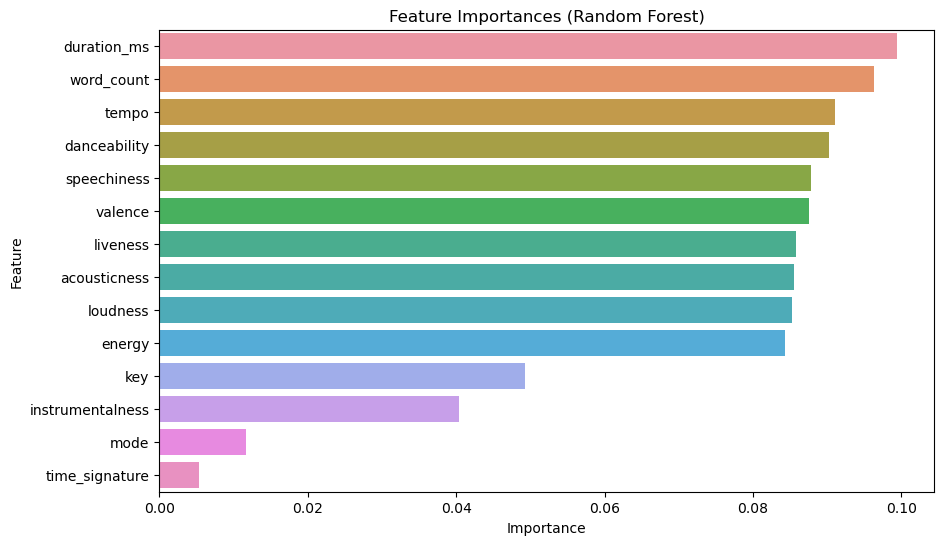

In [34]:
# Initialize a Random Forest classifier
rf = RandomForestClassifier()

# Fit the model to the data
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame to hold the feature importances
feature_importances = pd.DataFrame({"Feature": X.columns, "Importance": importances})
feature_importances = feature_importances.sort_values("Importance", ascending=False)

# Print the feature importances
print("Feature Importances:")
print(feature_importances)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(y=feature_importances["Feature"], x=feature_importances["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances (Random Forest)")
plt.show()

#### Gradient Boosting Classifier (GBC) Model

Feature Importances:
             Feature  Importance
11       duration_ms    0.189709
13        word_count    0.160470
10             tempo    0.109216
0       danceability    0.099363
5        speechiness    0.098970
9            valence    0.094967
3           loudness    0.062085
1             energy    0.048922
8           liveness    0.048741
6       acousticness    0.032438
7   instrumentalness    0.029820
2                key    0.017325
12    time_signature    0.006593
4               mode    0.001381


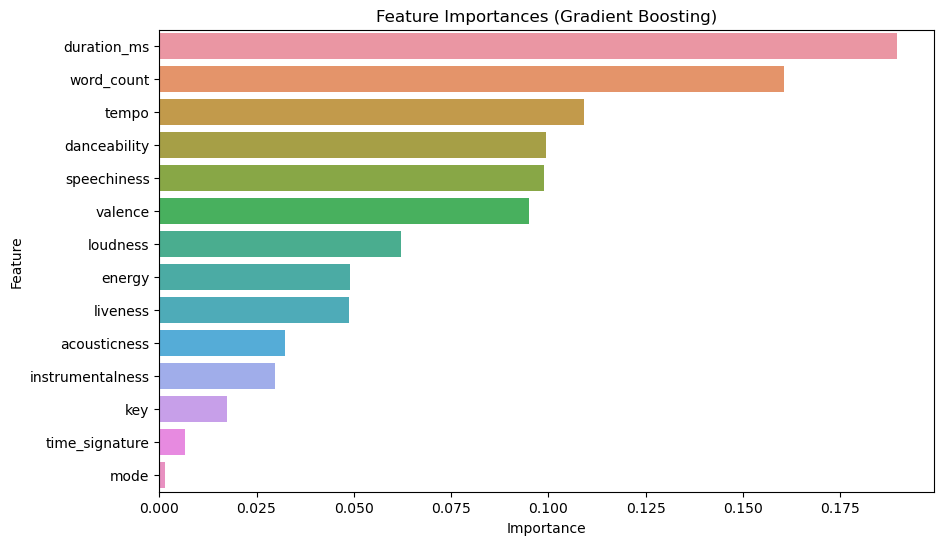

In [35]:
# Initialize a Gradient Boosting Classifier
gb = GradientBoostingClassifier()

# Fit the model to the data
gb.fit(X, y)

# Get feature importances
importances = gb.feature_importances_

# Create a DataFrame to hold the feature importances
feature_importances = pd.DataFrame({"Feature": X.columns, "Importance": importances})
feature_importances = feature_importances.sort_values("Importance", ascending=False)

# Print the feature importances
print("Feature Importances:")
print(feature_importances)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(y=feature_importances["Feature"], x=feature_importances["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances (Gradient Boosting)")
plt.show()

#### Intepretation of Feature Importances Plots:
- It can be seen from both RFC and GBC Feature Importances barplots that mode, time_signature, key and instrumentalness are 4 of the least important features.
- Hence, we will not use these 4 features for our analysis.

## EDA (Lyrics)

In [36]:
# Wordcloud formation function based on 'hit or non-hit' lyrics
def create_wordcloud(dataframe, lyrics):
    """
    Generates a word cloud based on the input 'hit or non-hit lyrics.
    
    Args:
    - text (str): The text to generate the word cloud from.
    
    Returns:
    - None
    """
    # combine all strings into a single string
    text = ' '.join(dataframe[lyrics])

    # create a WordCloud object with max_words=50
    cloud = WordCloud(max_words=50).generate(text).generate(text)

    # plot the word Cloud visualization
    plt.figure(figsize=(15,15))
    plt.imshow(cloud,interpolation='bilinear')
    plt.axis('off')
    plt.show();
    
    return None

In [37]:
# Creating a hits dataframe
hits_df = final_df.loc[final_df['hit'] == 1]

In [38]:
# Creating a non hits dataframe
nonhits_df = final_df.loc[final_df['hit'] == 0]

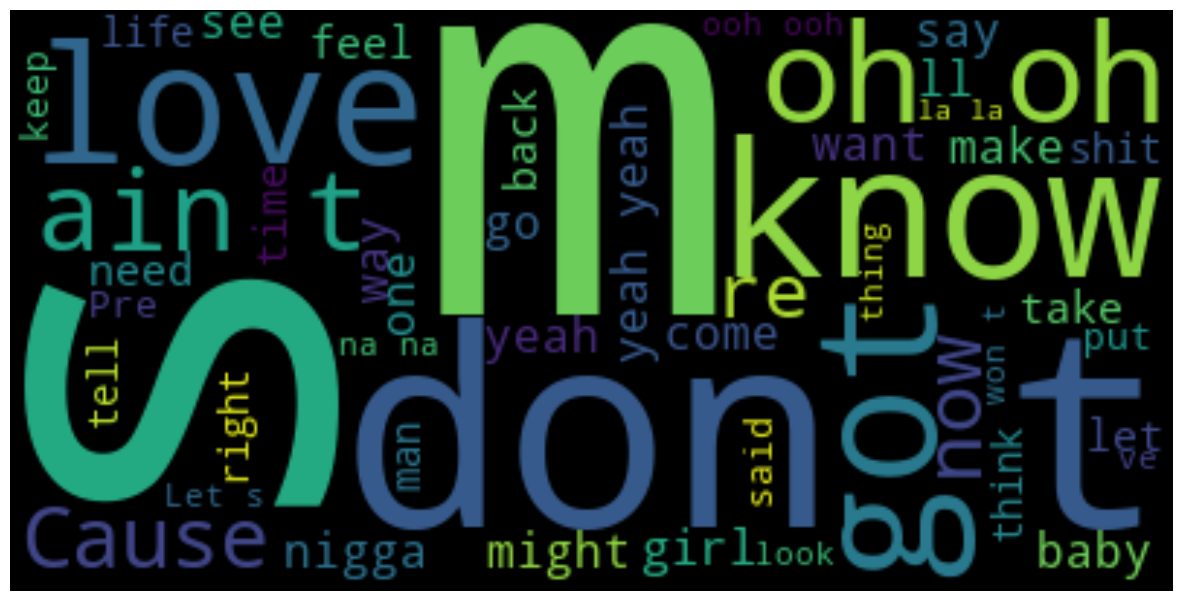

In [39]:
# WordCloud for hits
create_wordcloud(hits_df, 'cleaned_lyrics')

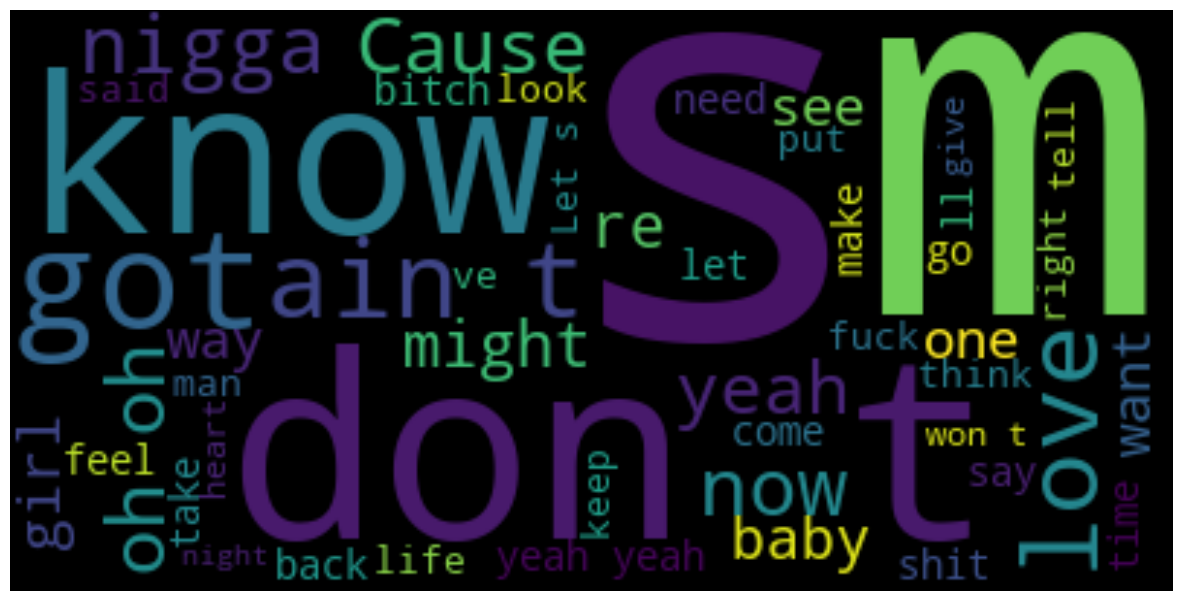

In [40]:
# WordCloud for nonhits
create_wordcloud(nonhits_df, 'cleaned_lyrics')

From both the above wordclouds, we will take out additional common words.

## Export final_df with the necessary features

In [41]:
# Set the maximum number of displayed columns
pd.set_option('display.max_columns', 100)

# Checking the fist 5 rows of final_df
final_df.head()

,artist,song,peak-rank,lyrics,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genres,cleaned_lyrics,word_count,Detected Languages,Lyrics_Langs,hit,a cappella,acoustic pop,acoustic rock,adult contemporary,adult standards,afrobeats,afrofuturism,afropop,afroswing,alabama indie,alabama metal,alabama rap,alaska indie,alberta country,album rock,albuquerque indie,alt z,alternative dance,alternative hip hop,alternative metal,alternative pop,alternative r&b,alternative rock,alternative roots rock,american folk revival,ann arbor indie,anti-folk,...,trancecore,transpop,trap,trap boricua,trap latino,trap queen,trap soul,traphall,tribal house,trinibad,trip hop,tropical,tropical house,turntablism,uk alternative pop,uk americana,uk contemporary r&b,uk dance,uk funky,uk garage,uk hip hop,uk pop,underground hip hop,upstate ny rap,urban contemporary,urbano latino,vapor pop,vapor trap,vincy soca,viral pop,viral rap,viral trap,virgin islands reggae,virginia hip hop,vocal house,vocal jazz,voice,washington indie,west coast rap,west coast trap,west end,westcoast flow,western swing,women's music,world worship,worship,wrestling,wu fam,yacht rock,yodeling
0,"""Weird Al"" Yankovic",Canadian Idiot,82,[Verse 1]\nDon't wanna be a Canadian idiot\nDo...,0.543,0.697,8,-9.211,1,0.0612,0.00206,0.000002,0.3430,0.861,5.225628,11.870880,4,"[comedy rock, comic, parody]",Don t wanna be a Canadian idiot Don t wanna be...,5.463832,[en:0.999997361772268],[en],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"""Weird Al"" Yankovic",White & Nerdy,9,[Chorus]\nThey see me mowin' my front lawn\nI ...,0.791,0.613,1,-11.628,0,0.0763,0.09860,0.000000,0.0765,0.896,4.962964,12.047311,4,"[comedy rock, comic, parody]",They see me mowin my front lawn I know they re...,6.532334,[en:0.9999960783163335],[en],1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"""Weird Al"" Yankovic",Word Crimes,39,[Intro]\nEverybody shut up! (Woo!)\nEveryone l...,0.897,0.430,7,-12.759,1,0.0551,0.01180,0.000000,0.0473,0.964,4.803914,12.315465,4,"[comedy rock, comic, parody]",Everybody shut up Woo Everyone listen up Hey h...,6.535241,[en:0.9999972194024291],[en],1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,N Sync,Bye Bye Bye,4,"[Intro: Justin & All]\nHey, hey\nBye bye bye\n...",0.610,0.926,8,-4.843,0,0.0479,0.03100,0.001200,0.0821,0.861,5.151197,12.208071,4,"[boy band, dance pop, pop]",Justin All Hey hey Bye bye bye Bye bye Bye bye...,6.228511,[en:0.9999949783141394],[en],1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,N Sync,I Drive Myself Crazy,67,"[Intro: Chris]\nOh oh, oh oh\nOh oh, oh oh oh....",0.495,0.704,9,-5.260,1,0.0331,0.01840,0.000000,0.1900,0.407,5.159377,12.387281,4,"[boy band, dance pop, pop]",Chris Oh oh oh oh Oh oh oh oh oh Chris Lying...,6.028279,[en:0.9999976800710364],[en],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
final_df.drop(['artist','song','peak-rank','lyrics','instrumentalness','key','mode','time_signature','genres','Detected Languages','Lyrics_Langs'], axis=1, inplace=True)

In [43]:
final_df.to_csv('./data/final_df.csv', encoding='UTF8', index=False)